# **Inference**

Import modules and packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
gc.collect()

import cv2
import time

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"]=False

# Import pytorch modules
import torch
torch.cuda.empty_cache()

# Import local modules
from src import config as C
from src.models import resnet50d
from src.utils.collate_fn import *
from src.utils.print_overwrite import *
from src.dataset import w300_dataset as W

device = 'cpu'

Dataset and Dataloader

In [2]:
w_dataset = W.FaceLandmarksDataset(transform=W.Transforms(), type="valid")
w_dataloader = torch.utils.data.DataLoader(w_dataset, batch_size=16, shuffle=True, num_workers=4)

Inference

Total number of test images: 417
Elapsed Time : 6.069357395172119


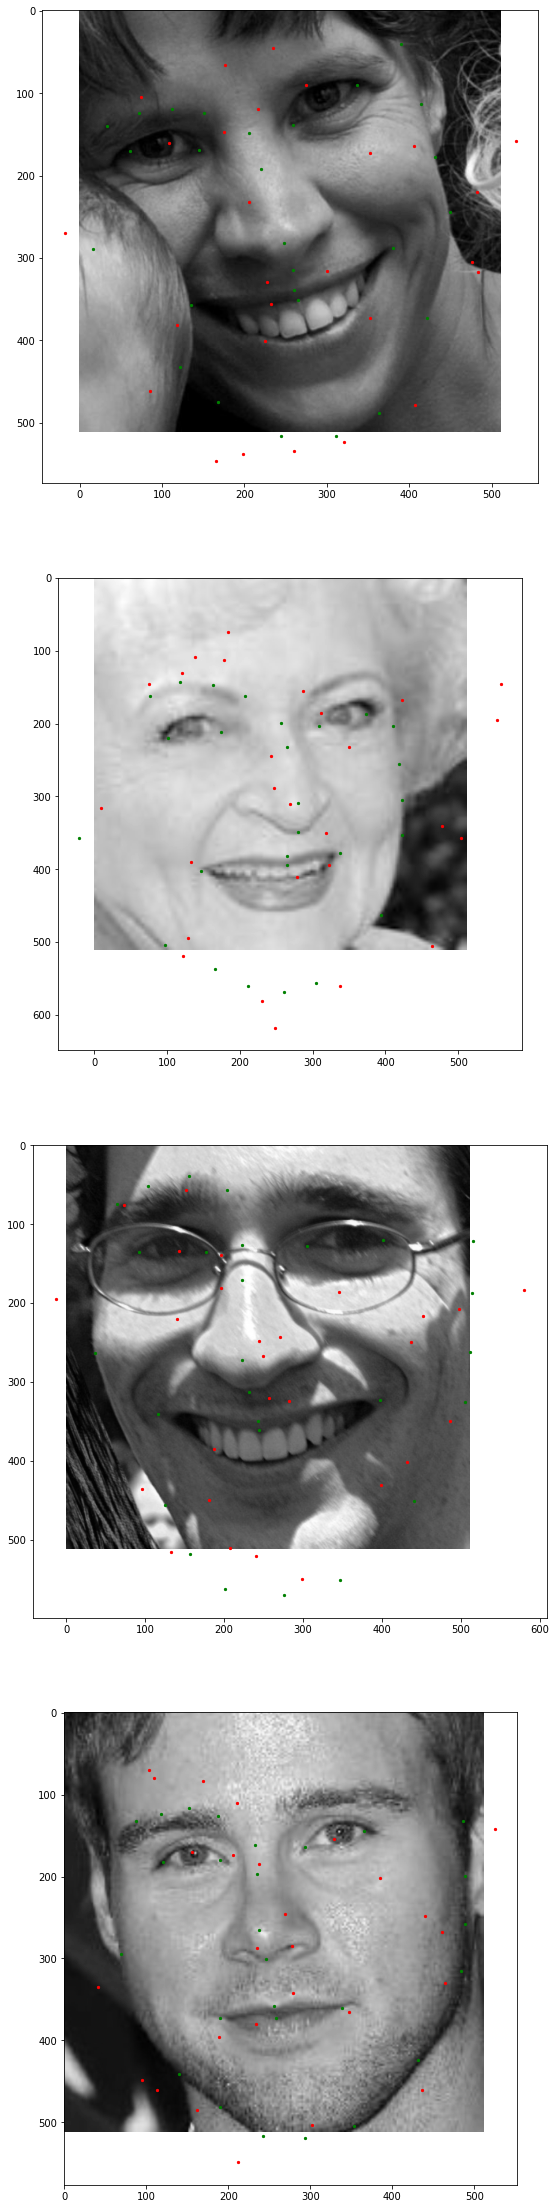

In [3]:
model = resnet50d.FaceSynthetics().cpu()
state_dict = torch.load('/home/ubuntu/workspace/FLD-scratch/result/face_landmarks.pth',map_location='cpu')
model.load_state_dict(state_dict)
model = model.to(device)

start_time = time.time()

with torch.no_grad():
    
    images, landmarks = next(iter(w_dataloader))
    
    images = images.to(device)
    landmarks = (landmarks) * 512 #* torch.tensor((512,512))    

    predictions = model(images).cpu()
    predictions = (predictions) * 512 # torch.tensor((512,512))  
    predictions = predictions.view([-1,27,2])
    
    num_view = 4
    
    plt.figure(figsize=(10,num_view*10))
    for img_num in range(num_view):
        image = images[img_num].cpu().numpy().transpose(1,2,0).squeeze()
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        plt.subplot(num_view,1,img_num+1)
        plt.imshow(image, cmap='gray')
        plt.scatter(predictions[img_num].T[0], predictions[img_num].T[1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num].T[0], landmarks[img_num].T[1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(w_dataloader)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 